In [1]:
import cv2
import os
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import time
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from imgaug import augmenters as iaa
from scipy.io import loadmat
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold
# !pip list

Package                      Version
---------------------------- -------------------
absl-py                      2.0.0
anyio                        3.7.1
argon2-cffi                  21.3.0
argon2-cffi-bindings         21.2.0
asgiref                      3.7.2
asttokens                    2.0.7
astunparse                   1.6.3
attrs                        22.1.0
Audio-DeSilencer             1.0.2
backcall                     0.2.0
beautifulsoup4               4.11.1
bleach                       5.0.1
blinker                      1.7.0
cachetools                   5.3.2
certifi                      2023.11.17
cffi                         1.15.1
charset-normalizer           3.3.2
click                        8.1.7
colorama                     0.4.6
contourpy                    1.2.1
cryptography                 37.0.4
cycler                       0.11.0
debugpy                      1.6.2
decorator                    5.1.1
defusedxml                   0.7.1
dill                       

In [3]:
def load_raf_dataset(dataset_path):
    images = []
    labels = []
    image_paths = []
    emotion_mapping = {
        "Happily Surprised": 1,
        "Happily Disgusted": 2,
        "Sadly Fearful": 3,
        "Sadly Angry": 4,
        "Sadly Surprised": 5,
        "Sadly Disgusted": 6,
        "Fearfully Angry": 7,
        "Fearfully Surprised": 8,
        "Angrily Surprised": 9,
        "Angrily Disgusted": 10,
        "Disgustedly Surprised": 11
    }

    # Define augmentation sequence
    seq = iaa.Sequential([
        iaa.Fliplr(0.5),  # horizontal flips
        iaa.Crop(percent=(0, 0.1)),  # random crops
        iaa.LinearContrast((0.75, 1.5)),  # adjust contrast
        iaa.Multiply((0.8, 1.2), per_channel=0.2),  # random brightness
        iaa.Affine(
            rotate=(-20, 20),  # rotate by -20 to +20 degrees
            shear=(-16, 16)  # shear by -16 to +16 degrees
        )
    ])

    for emotion, label in emotion_mapping.items():
        emotion_dir = os.path.join(dataset_path, emotion)
        if not os.path.isdir(emotion_dir):
            continue

        for image_name in os.listdir(emotion_dir):
            if image_name.endswith('_aligned.jpg'):
                image_path = os.path.join(emotion_dir, image_name)
                image_paths.append(image_path)
                img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    img = cv2.resize(img, (64, 64))
                    images.append(img.flatten())
                    labels.append(label)  # Use emotion label directly

                    # Apply augmentation to increase dataset
                    for _ in range(5):  # Generate 5 augmented images for each original image
                        img_aug = seq(image=img)
                        images.append(img_aug.flatten())
                        labels.append(label)

    return np.array(images), np.array(labels), emotion_mapping, image_paths

# Example usage
dataset_path = r'original'
images, labels, emotion_mapping, image_paths = load_raf_dataset(dataset_path)

Grid search completed in 172.87 seconds.
Best parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Prediction completed in 6.38 seconds.
Accuracy: 79.73%
Classification Report:
                       precision    recall  f1-score   support

    Happily Surprised       0.75      0.48      0.59      1030
    Happily Disgusted       0.73      0.96      0.83      1002
        Sadly Fearful       0.85      1.00      0.92      1015
          Sadly Angry       0.82      0.99      0.90      1046
      Sadly Surprised       0.80      1.00      0.89      1001
      Sadly Disgusted       0.71      0.42      0.53       993
      Fearfully Angry       0.91      0.99      0.95       996
  Fearfully Surprised       0.80      0.72      0.75       992
    Angrily Surprised       0.81      0.99      0.89      1014
    Angrily Disgusted       0.71      0.24      0.36      1032
Disgustedly Surprised       0.77      1.00      0.87       981

             accuracy                    

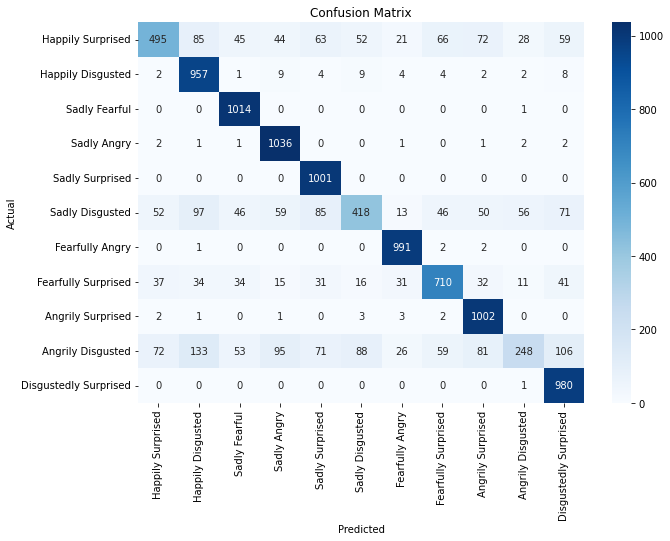

Unique predicted labels: [ 1  2  3  4  5  6  7  8  9 10 11]
KeyError: 4 - Check if the predicted labels match the expected range.
Unique labels in predictions: [ 1  2  3  4  5  6  7  8  9 10 11]


In [4]:
# Check if images and labels are populated
if len(images) == 0 or len(labels) == 0:
    raise ValueError("No images or labels were loaded. Please check the dataset path and image processing steps.")

# Normalize the data
scaler = StandardScaler()
images = scaler.fit_transform(images)

# Apply PCA
pca = PCA(n_components=0.95)  # Adjust the explained variance as needed
images_pca = pca.fit_transform(images)

# Apply SMOTE for balancing
smote = SMOTE()
images_resampled, labels_resampled = smote.fit_resample(images_pca, labels)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(images_resampled, labels_resampled, test_size=0.2, random_state=42)

# Define parameter grid for hyperparameter tuning
param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
start_time = time.time()
grid_search.fit(X_train, y_train)
print(f"Grid search completed in {(time.time() - start_time):.2f} seconds.")
print(f"Best parameters: {grid_search.best_params_}")

# Initialize StratifiedKFold for preserving the percentage of samples for each class
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Get the best estimator
knn = grid_search.best_estimator_

# Perform cross-validation
cv_scores = cross_val_score(knn, images_resampled, labels_resampled, cv=skf, scoring='accuracy')

# Print the cross-validation results
print("Cross-validation scores for each fold: ", cv_scores)
print("Mean cross-validation accuracy: {:.2f}%".format(cv_scores.mean() * 100))
print("Standard deviation of cross-validation accuracy: {:.2f}%".format(cv_scores.std() * 100))

# Predict on the test set
start_time = time.time()
y_pred = knn.predict(X_test)
print(f"Prediction completed in {(time.time() - start_time):.2f} seconds.")

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=[emotion for emotion in emotion_mapping]))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[emotion for emotion in emotion_mapping], yticklabels=[emotion for emotion in emotion_mapping])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Check the unique labels in y_pred
unique_labels_pred = np.unique(y_pred)
print(f"Unique predicted labels: {unique_labels_pred}")

# Decode labels back to original emotion classes for readability
try:
    y_pred_emotions = [emotion_mapping[label] for label in y_pred]
    y_test_emotions = [emotion_mapping[label] for label in y_test]
except KeyError as e:
    print(f"KeyError: {e} - Check if the predicted labels match the expected range.")
    print(f"Unique labels in predictions: {unique_labels_pred}")

# Reverse mapping for prediction
reverse_emotion_mapping = {v: k for k, v in emotion_mapping.items()}

def predict_new_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = cv2.resize(img, (64, 64))
        img_flattened = img.flatten().reshape(1, -1)  # Reshape for prediction
        img_flattened_scaled = scaler.transform(img_flattened)  # Scale the new image
        img_flattened_pca = pca.transform(img_flattened_scaled)  # Apply PCA to the new image
        start_time = time.time()
        prediction = knn.predict(img_flattened_pca)
        print(f"Prediction for new image completed in {(time.time() - start_time):.2f} seconds.")
        
        predicted_label = prediction[0]
        if predicted_label in reverse_emotion_mapping:
            predicted_emotion = reverse_emotion_mapping[predicted_label]
            return predicted_emotion
        else:
            raise ValueError(f"Predicted label {predicted_label} not found in emotion mapping.")
    else:
        raise FileNotFoundError(f"Image at {image_path} not found.")

In [9]:
# Change the path to the new image you want to predict
new_image_path = 'test_378_aligned_fearfully_surprised.jpg'  # Update this path to match your uploaded file

predicted_emotion = predict_new_image(new_image_path)
print(f"The predicted emotion for the new image is: {predicted_emotion}")

Prediction for new image completed in 0.00 seconds.
The predicted emotion for the new image is: Fearfully Surprised
